In [14]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os

print("--- Predicting Magic: The Gathering Card Prices (Linear Regression Baseline) ---")
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

--- Predicting Magic: The Gathering Card Prices (Linear Regression Baseline) ---


In [15]:
# 1. LOAD FILES
identifiers_file = 'AllIdentifiers.json'
prices_file = 'AllPrices.json'
sets_file = 'SetList.json'

if not all(os.path.exists(f) for f in [identifiers_file, prices_file, sets_file]):
    print("ERROR: Files missing!")
else:
    print("1. Loading files...")
    with open(identifiers_file, 'r', encoding='utf-8') as f:
        identifiers = json.load(f)['data']
    with open(prices_file, 'r', encoding='utf-8') as f:
        prices = json.load(f)['data']
    with open(sets_file, 'r', encoding='utf-8') as f:
        sets_data = json.load(f)['data']
    print("✅ Files loaded.")

# Set Dates
set_dates = {}
for set_info in sets_data:
    code = set_info.get('code')
    date_str = set_info.get('releaseDate')
    if code and date_str:
        set_dates[code] = date_str

1. Loading files...
✅ Files loaded.


In [16]:
# 2. DATA PROCESSING
print("2. Processing data...")

data_rows = []
today = datetime.now()

for uuid, price_data in prices.items():
    if uuid not in identifiers: continue
    card_info = identifiers[uuid]

    meta_rank = card_info.get('edhrecRank')
    if meta_rank is None: continue

    # Features
    is_reserved = 1 if card_info.get('isReserved', False) else 0
    cmc = card_info.get('manaValue', 0.0)
    types = card_info.get('types', [])
    is_land = 1 if 'Land' in types else 0
    is_legendary = 1 if 'Legendary' in card_info.get('supertypes', []) else 0

    legalities = card_info.get('legalities', {})
    is_legal_commander = 1 if legalities.get('commander') == 'Legal' else 0
    is_legal_modern = 1 if legalities.get('modern') == 'Legal' else 0

    set_code = card_info.get('setCode')
    card_age_days = 0
    if set_code in set_dates:
        release_date = datetime.strptime(set_dates[set_code], '%Y-%m-%d')
        card_age_days = (today - release_date).days

    # Price Extraction
    found_prices = {}
    platforms = []
    if 'paper' in price_data: platforms.append(price_data['paper'])

    for platform in platforms:
        if len(found_prices) == 2: break
        stores = ['cardkingdom', 'tcgplayer', 'cardmarket']
        for store in stores:
            if store in platform and 'retail' in platform[store]:
                retail = platform[store]['retail']

                if 'normal' not in found_prices and 'normal' in retail:
                    price_series = retail['normal']
                    if price_series:
                        dates = sorted(list(price_series.keys()))[-90:]
                        vals = [price_series[d] for d in dates if price_series[d]]
                        if vals: found_prices['normal'] = sum(vals) / len(vals)

                if 'foil' not in found_prices and 'foil' in retail:
                    price_series = retail['foil']
                    if price_series:
                        dates = sorted(list(price_series.keys()))[-90:]
                        vals = [price_series[d] for d in dates if price_series[d]]
                        if vals: found_prices['foil'] = sum(vals) / len(vals)

    # Appending
    base_row = {
        'MetaRank': float(meta_rank),
        'Rarity': card_info.get('rarity', 'common'),
        'IsReserved': is_reserved,
        'CMC': float(cmc),
        'IsLand': is_land,
        'IsLegendary': is_legendary,
        'IsLegalCommander': is_legal_commander,
        'IsLegalModern': is_legal_modern,
        'CardAgeDays': card_age_days
    }

    if 'normal' in found_prices:
        row = base_row.copy()
        row.update({'IsFoil': 0, 'Price': float(found_prices['normal'])})
        data_rows.append(row)

    if 'foil' in found_prices:
        row = base_row.copy()
        row.update({'IsFoil': 1, 'Price': float(found_prices['foil'])})
        data_rows.append(row)

df = pd.DataFrame(data_rows)
print(f"3. Dataset Ready! {len(df)} rows.")

# Cleaning (< 200$)
df_clean = df[(df['Price'] < 200) & (df['MetaRank'] < 26000)].copy()
df_clean['LogPrice'] = np.log1p(df_clean['Price'])

print(f"Number of analyzed cards: {len(df_clean)}")

2. Processing data...
3. Dataset Ready! 145120 rows.
Number of analyzed cards: 133207


4. Preparing Charts and Tables...

##################################################
 TABLE 1: Normal and Foil Card Price Comparison
##################################################
Card Type  Count  Avg Price ($)  Min    Max  Std Dev
     Foil  59169           7.45 0.01 200.00    17.97
   Normal  73490           3.62 0.02 199.99    11.34


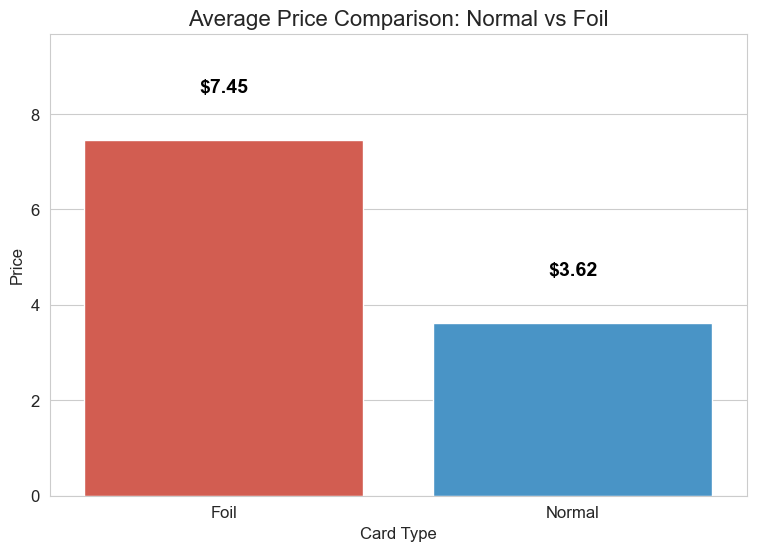

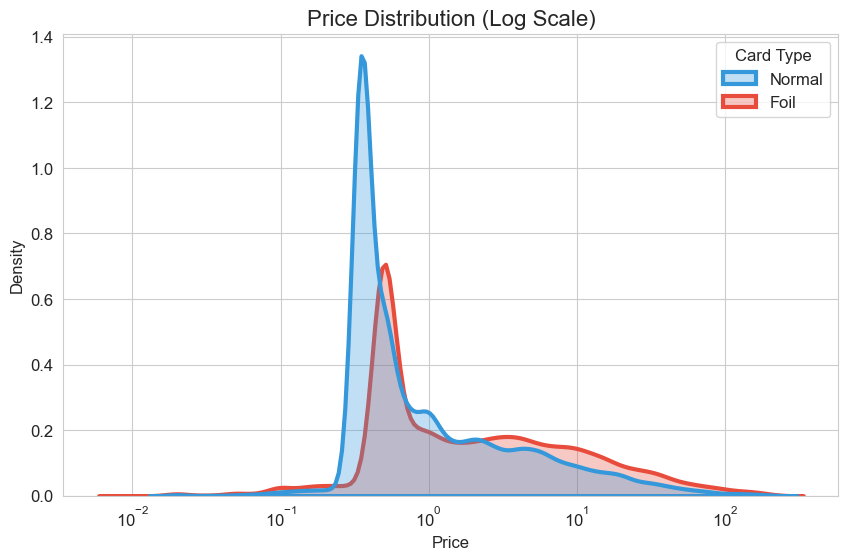


##################################################
 TABLE 2: Price Analysis by Rarity Level
##################################################
  Rarity  Card Count  Avg Price ($)  Median ($)  Max Price ($)
  common       31966           1.49        0.40         199.99
uncommon       33482           2.46        0.49         199.99
    rare       53324           6.82        1.66         199.99
  mythic       13887          15.35        6.34         200.00


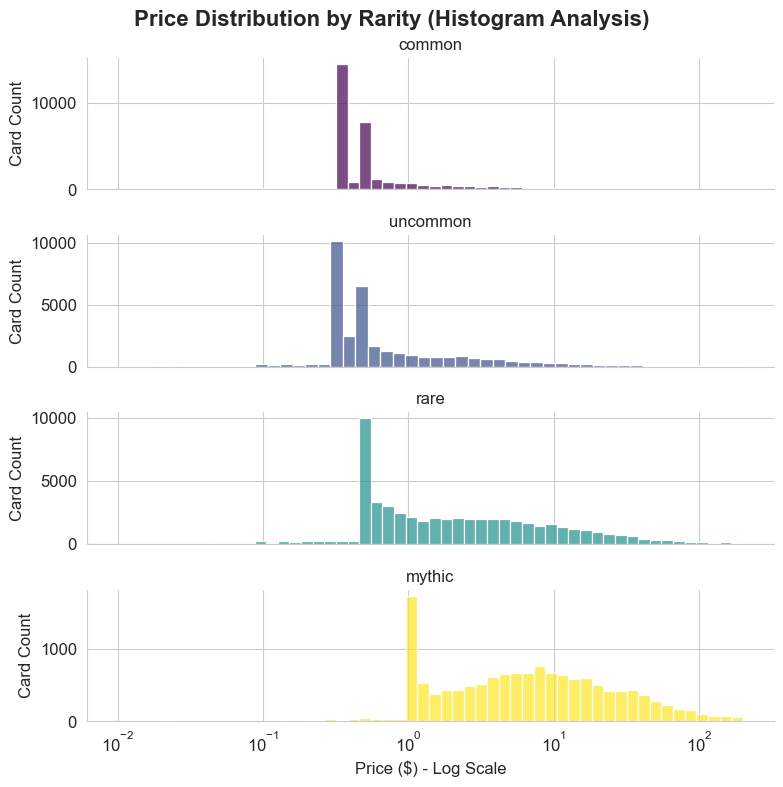


##################################################
 TABLE 3: Market Segmentation
##################################################
      Category  Card Count  Percentage (%)
  Budget (<$1)       74826           56.40
  Mid ($1-$10)       41763           31.48
High ($10-$50)       13526           10.20
Premium ($50+)        2544            1.92


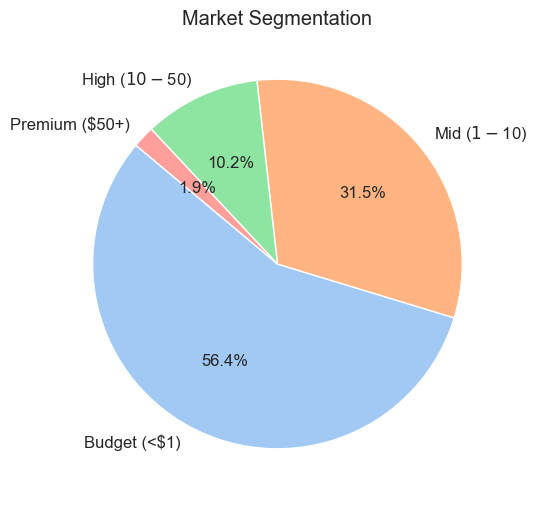


##################################################
 TABLE 4: Correlation Coefficients
##################################################
             Price
Price         1.00
IsFoil        0.13
IsLegendary   0.11
IsReserved    0.08
CardAgeDays   0.07
CMC          -0.00
MetaRank     -0.20


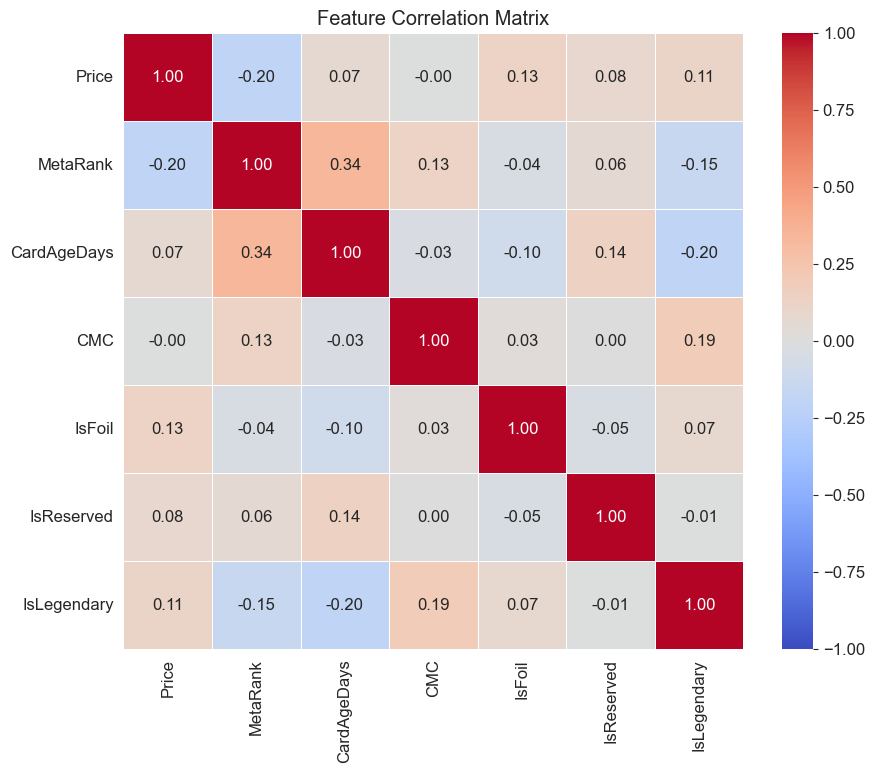


############################################################
 TABLE 6: Meta Tier List (Popularity vs Price)
############################################################
                      Card Count  Avg Price ($)  Median ($)  Max Price ($)
Meta_Category                                                             
God Tier (Top 100)          3854          15.05        3.78         197.34
Top Tier (101-500)          7270          11.81        3.24         199.99
High Tier (501-1000)        6432          10.64        3.53         199.95
Mid Tier (1k-5k)           30274           8.07        2.56         200.00
Low Tier (5k-10k)          26260           4.06        0.91         199.99
Bulk (>10k)                58569           2.45        0.49         199.99
############################################################


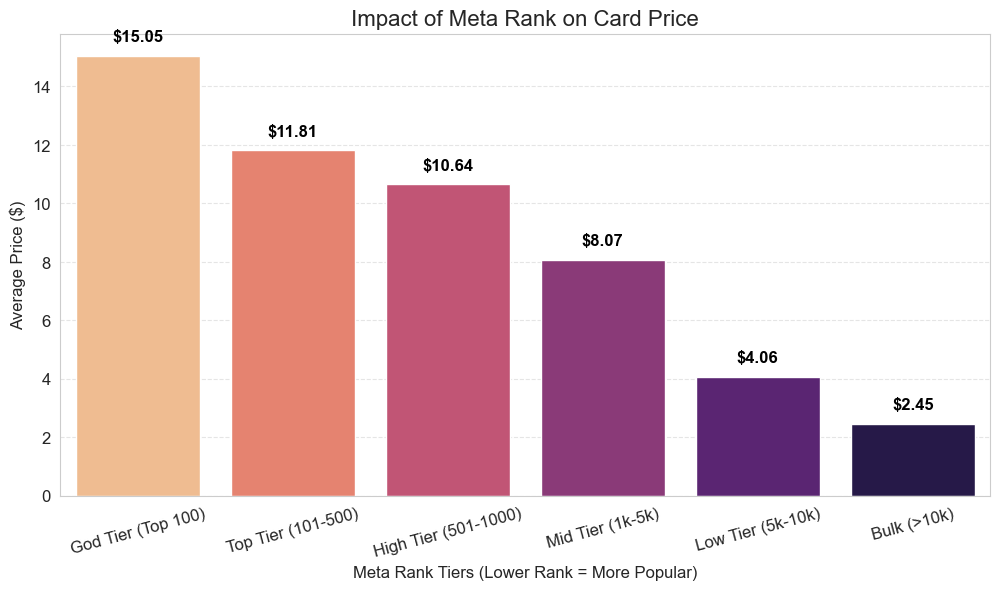


##################################################
 ANALYSIS 7: Vintage Effect (Rares Only)
##################################################


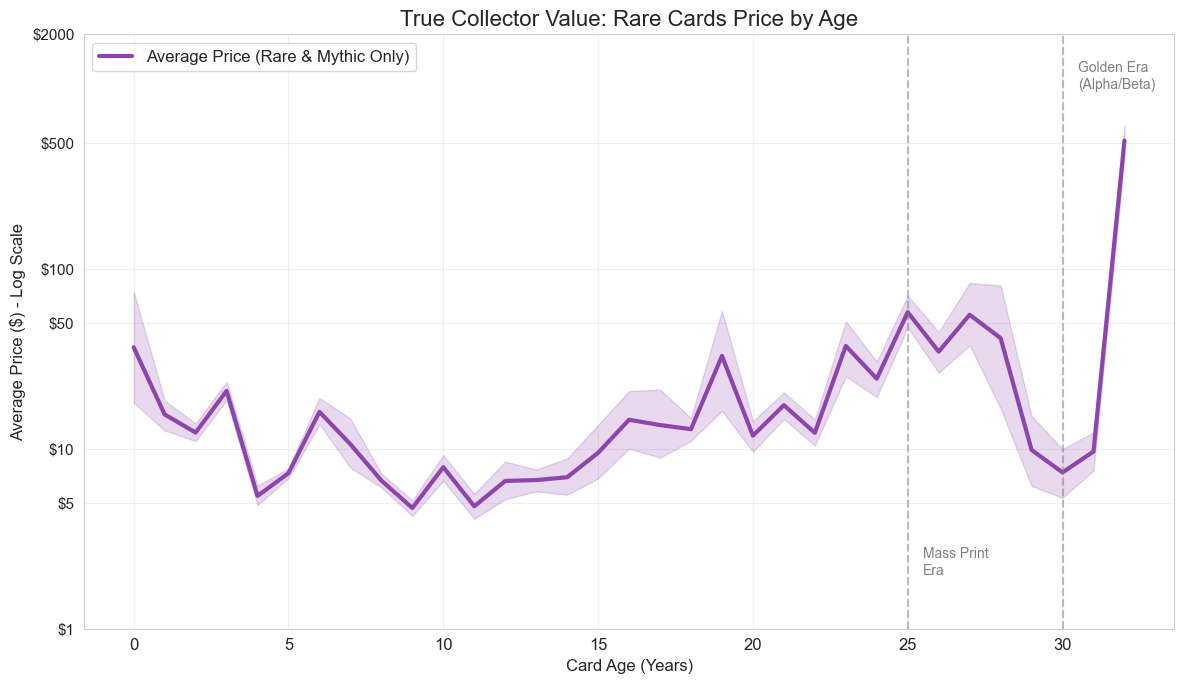

In [17]:
# ========================================================
# 3. VISUALIZATION (EXISTING CHARTS)
# ========================================================
print("4. Preparing Charts and Tables...")

# Table Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# --- DATA CLEANING ---
target_rarities = ['common', 'uncommon', 'rare', 'mythic']
df_clean = df_clean[df_clean['Rarity'].isin(target_rarities)].copy()

# Preparation
df_vis = df_clean.copy()
df_vis['Card Type'] = df_vis['IsFoil'].map({0: 'Normal', 1: 'Foil'})

# ========================================================
# ANALYSIS 1: NORMAL vs FOIL
# ========================================================
print("\n" + "#"*50)
print(" TABLE 1: Normal and Foil Card Price Comparison")
print("#"*50)

type_stats = df_vis.groupby('Card Type')['Price'].agg(['count', 'mean', 'min', 'max', 'std'])
type_stats.columns = ['Count', 'Avg Price ($)', 'Min', 'Max', 'Std Dev']
print(type_stats.reset_index().to_string(index=False))

# --- CHART 1 ---
plt.figure(figsize=(9, 6))
avg_prices = df_vis.groupby('Card Type')['Price'].mean().reset_index()
sns.barplot(
    x='Card Type', y='Price', data=avg_prices,
    hue='Card Type', legend=False, palette={'Normal': '#3498db', 'Foil': '#e74c3c'}
)
# Fix for "Hashable" error
for index, row in avg_prices.iterrows():
    plt.text(float(index), row.Price + 1, f"${row.Price:.2f}", color='black', ha="center", fontsize=14, fontweight='bold')

max_val = avg_prices['Price'].max()
plt.ylim(0, max_val * 1.3)
plt.title('Average Price Comparison: Normal vs Foil', fontsize=16)
plt.show()

# ========================================================
# ANALYSIS 2: PRICE DISTRIBUTION (GENERAL)
# ========================================================
# --- CHART 2 ---
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_vis, x='Price', hue='Card Type',
    palette={'Normal': '#3498db', 'Foil': '#e74c3c'},
    log_scale=True, fill=True, alpha=0.3, linewidth=3
)
plt.title('Price Distribution (Log Scale)', fontsize=16)
plt.show()

# ========================================================
# ANALYSIS 3: RARITY ANALYSIS (HISTOGRAMS)
# ========================================================
print("\n" + "#"*50)
print(" TABLE 2: Price Analysis by Rarity Level")
print("#"*50)

rarity_order = ['common', 'uncommon', 'rare', 'mythic']
rarity_stats = df_clean.groupby('Rarity')['Price'].agg(['count', 'mean', 'median', 'max'])
rarity_stats = rarity_stats.reindex(rarity_order)
rarity_stats.columns = ['Card Count', 'Avg Price ($)', 'Median ($)', 'Max Price ($)']
print(rarity_stats.reset_index().to_string(index=False))

# --- CHART 3: HISTOGRAMS ---
sns.set_style("whitegrid")

colors = {"common": "#440154", "uncommon": "#3b528b", "rare": "#21918c", "mythic": "#fde725"}

g = sns.FacetGrid(
    df_clean,
    row="Rarity",
    hue="Rarity",
    row_order=rarity_order,
    palette=colors,
    aspect=4,
    height=2,
    sharey=False
)

# Draw Histograms
g.map(sns.histplot, "Price", log_scale=True, bins=50, alpha=0.7)

# Settings
g.set_titles(row_template="{row_name}")
g.set_axis_labels("Price ($) - Log Scale", "Card Count")
plt.subplots_adjust(top=0.92)
g.figure.suptitle('Price Distribution by Rarity (Histogram Analysis)', fontsize=16, fontweight='bold')
plt.show()

# ========================================================
# ANALYSIS 4: MARKET SEGMENTATION
# ========================================================
print("\n" + "#"*50)
print(" TABLE 3: Market Segmentation")
print("#"*50)

bins = [-1, 1, 10, 50, float('inf')]
labels = ['Budget (<$1)', 'Mid ($1-$10)', 'High ($10-$50)', 'Premium ($50+)']
df_clean['Price_Category'] = pd.cut(df_clean['Price'], bins=bins, labels=labels)
segment_stats = df_clean['Price_Category'].value_counts().reset_index()
segment_stats.columns = ['Category', 'Card Count']
segment_stats['Percentage (%)'] = (segment_stats['Card Count'] / len(df_clean) * 100)
print(segment_stats.to_string(index=False))

plt.figure(figsize=(8, 6))
counts = df_clean['Price_Category'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Market Segmentation')
plt.show()

# ========================================================
# ANALYSIS 5: CORRELATION
# ========================================================
print("\n" + "#"*50)
print(" TABLE 4: Correlation Coefficients")
print("#"*50)

corr_features = ['Price', 'MetaRank', 'CardAgeDays', 'CMC', 'IsFoil', 'IsReserved', 'IsLegendary']
corr_matrix = df_clean[corr_features].corr()
print(corr_matrix[['Price']].sort_values(by='Price', ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

# ========================================================
# ANALYSIS 6: META (EDHREC RANK) ANALYSIS
# ========================================================
print("\n" + "#"*60)
print(" TABLE 6: Meta Tier List (Popularity vs Price)")
print("#"*60)

# 1. Binning
bins = [0, 100, 500, 1000, 5000, 10000, 999999]
labels = [
    'God Tier (Top 100)',
    'Top Tier (101-500)',
    'High Tier (501-1000)',
    'Mid Tier (1k-5k)',
    'Low Tier (5k-10k)',
    'Bulk (>10k)'
]

df_meta = df_clean.copy()
df_meta['Meta_Category'] = pd.cut(df_meta['MetaRank'], bins=bins, labels=labels)

# 2. Statistics Table
meta_stats = df_meta.groupby('Meta_Category', observed=False)['Price'].agg(['count', 'mean', 'median', 'max'])
meta_stats.columns = ['Card Count', 'Avg Price ($)', 'Median ($)', 'Max Price ($)']

print(meta_stats.to_string())
print("#"*60)

# --- CHART 6: META TIER ---
plt.figure(figsize=(12, 6))
meta_viz = meta_stats.reset_index()

sns.barplot(
    x='Meta_Category',
    y='Avg Price ($)',
    data=meta_viz,
    hue='Meta_Category',
    legend=False,
    palette='magma_r'
)

# Fix for "Hashable" error
for index, row in meta_viz.iterrows():
    plt.text(float(index), row['Avg Price ($)'] + 0.5, f"${row['Avg Price ($)']:.2f}",
             color='black', ha="center", fontweight='bold')

plt.title('Impact of Meta Rank on Card Price', fontsize=16)
plt.ylabel('Average Price ($)')
plt.xlabel('Meta Rank Tiers (Lower Rank = More Popular)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# ========================================================
# ANALYSIS 7: CARD AGE AND PRICE RELATIONSHIP (VINTAGE TREND)
# ========================================================
print("\n" + "#"*50)
print(" ANALYSIS 7: Vintage Effect (Rares Only)")
print("#"*50)

df_vintage = df[
    (df['MetaRank'] < 26000) &
    (df['Rarity'].isin(['rare', 'mythic']))
].copy()

df_vintage['AgeYears'] = df_vintage['CardAgeDays'] / 365
df_vintage['AgeRound'] = df_vintage['AgeYears'].round()

# --- CHART 7 ---
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=df_vintage,
    x='AgeRound',
    y='Price',
    color='#8e44ad',
    linewidth=3,
    label='Average Price (Rare & Mythic Only)'
)

plt.yscale('log')

y_ticks = [1, 5, 10, 50, 100, 500, 2000]
plt.yticks(y_ticks, [f"${y}" for y in y_ticks], fontsize=11)

plt.title('True Collector Value: Rare Cards Price by Age', fontsize=16)
plt.xlabel('Card Age (Years)', fontsize=12)
plt.ylabel('Average Price ($) - Log Scale', fontsize=12)

plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5)
plt.text(30.5, 1000, 'Golden Era\n(Alpha/Beta)', fontsize=10, color='gray')

plt.axvline(x=25, color='gray', linestyle='--', alpha=0.5)
plt.text(25.5, 2, 'Mass Print\nEra', fontsize=10, color='gray')

plt.xticks(np.arange(0, 35, 5))
plt.grid(True, which="major", ls="-", alpha=0.3)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

5. Training Linear Regression (Baseline Model)...

       FINAL RESULTS (LINEAR REGRESSION)       
🔥 R2 SCORE    : 0.4109
📉 RMSE Error  : 14.55 $

--- Model Coefficients (Impact Power) ---
             Feature  Coefficient
9      Rarity_mythic         1.39
1         IsReserved         0.74
10       Rarity_rare         0.59
5   IsLegalCommander        -0.40
8             IsFoil         0.39
6      IsLegalModern        -0.16
3             IsLand        -0.12
11   Rarity_uncommon         0.11
2                CMC        -0.03
4        IsLegendary         0.01


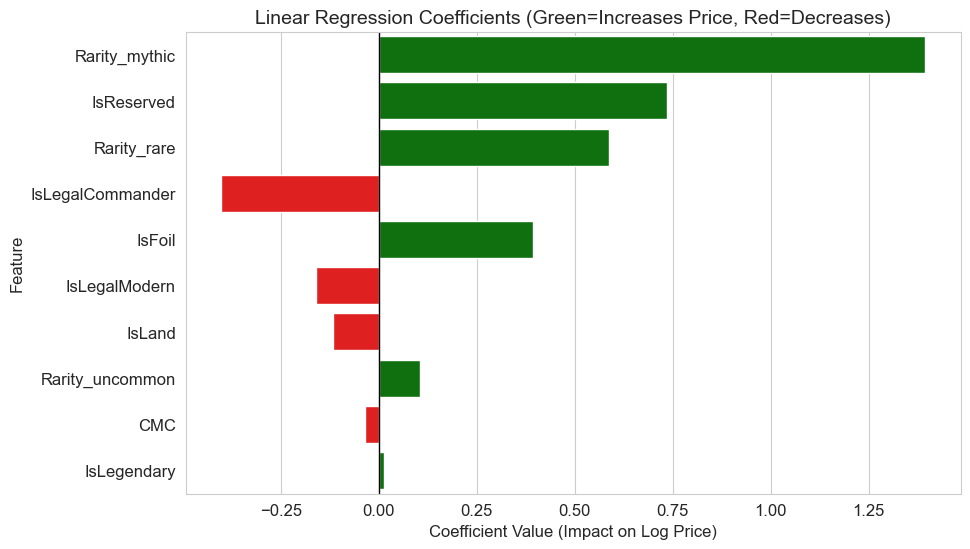


##################################################
 BONUS: Classification Success of Price Predictions
##################################################


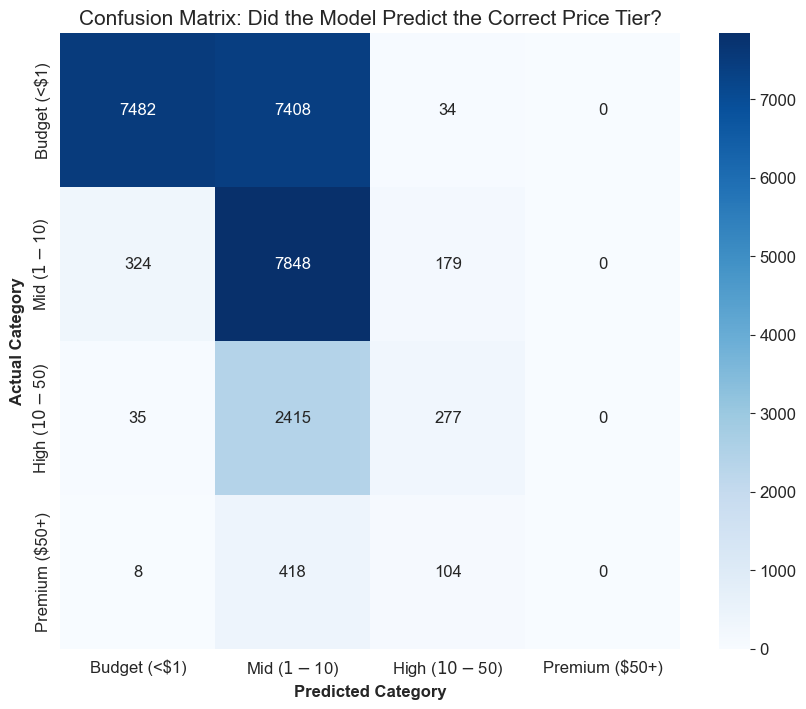


--- Classification Performance Report ---
                precision    recall  f1-score   support

  Budget (<$1)       0.95      0.50      0.66     14924
  Mid ($1-$10)       0.47      0.10      0.17      2727
High ($10-$50)       0.43      0.94      0.59      8351
Premium ($50+)       0.00      0.00      0.00       530

      accuracy                           0.59     26532
     macro avg       0.46      0.39      0.35     26532
  weighted avg       0.72      0.59      0.57     26532


############################################################
 FINAL CHECK: Reality vs. Predictions (Market Distribution)
############################################################
       Segment  Actual Count  Predicted Count  Diff
  Budget (<$1)         14924             7849 -7075
  Mid ($1-$10)          8351            18089  9738
High ($10-$50)          2727              594 -2133
Premium ($50+)           530                0  -530


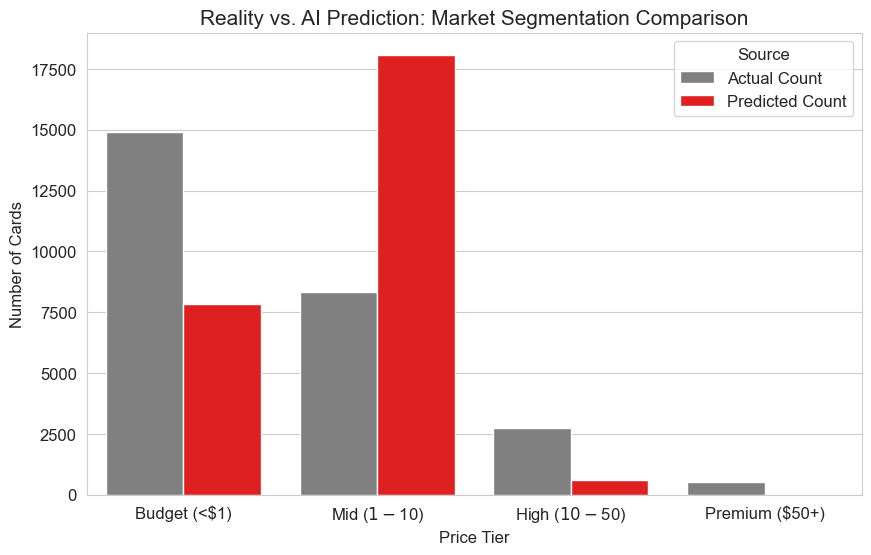

In [19]:
# 4. MODEL TRAINING (LINEAR REGRESSION)
print("5. Training Linear Regression (Baseline Model)...")

features = [
    'MetaRank', 'Rarity', 'IsReserved', 'CMC',
    'IsLand', 'IsLegendary',
    'IsLegalCommander', 'IsLegalModern',
    'CardAgeDays', 'IsFoil'
]

# One-Hot Encoding
df_model = pd.get_dummies(df_clean[features], drop_first=True)
X = df_model
y = df_clean['LogPrice']

# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- LINEAR REGRESSION MODEL ---
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_log = model.predict(X_test)
r2 = r2_score(y_test, y_pred_log)
mse_real = mean_squared_error(np.expm1(y_test), np.expm1(y_pred_log))

print(f"\n{'=' * 40}")
print(f"       FINAL RESULTS (LINEAR REGRESSION)       ")
print(f"{'=' * 40}")
print(f"🔥 R2 SCORE    : {r2:.4f}")
print(f"📉 RMSE Error  : {np.sqrt(mse_real):.2f} $")
print(f"{'=' * 40}")

# --- VISUALIZING COEFFICIENTS ---
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

# Sort by Absolute Value
coefficients['Abs_Coef'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coef', ascending=False).head(10)

print("\n--- Model Coefficients (Impact Power) ---")
print(coefficients[['Feature', 'Coefficient']])

plt.figure(figsize=(10, 6))
# Green for Positive, Red for Negative
colors = ['green' if c > 0 else 'red' for c in coefficients['Coefficient']]

sns.barplot(
    x='Coefficient',
    y='Feature',
    data=coefficients,
    hue='Feature',
    palette=colors,
    legend=False
)

plt.title('Linear Regression Coefficients (Green=Increases Price, Red=Decreases)', fontsize=14)
plt.xlabel('Coefficient Value (Impact on Log Price)', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.show()

# ========================================================
# BONUS: CLASSIFICATION SUCCESS & MARKET CHECK (WARNINGS FIXED)
# ========================================================
print("\n" + "#"*50)
print(" BONUS: Classification Success of Price Predictions")
print("#"*50)

# 1. Convert to Dollars
y_test_dollars = np.expm1(y_test)
y_pred_dollars = np.expm1(y_pred_log)

# 2. Categorize (FIXED BINS)
bins = [-1, 1, 10, 50, float('inf')]
labels = ['Budget (<$1)', 'Mid ($1-$10)', 'High ($10-$50)', 'Premium ($50+)']

# Use .astype(str) to prevent type errors
y_true_cat = pd.cut(y_test_dollars, bins=bins, labels=labels).astype(str)
y_pred_cat = pd.cut(y_pred_dollars, bins=bins, labels=labels).astype(str)

# Filter out 'nan'
valid_mask = (y_true_cat != 'nan') & (y_pred_cat != 'nan')
y_true_cat = y_true_cat[valid_mask]
y_pred_cat = y_pred_cat[valid_mask]

# 3. Confusion Matrix
cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix: Did the Model Predict the Correct Price Tier?', fontsize=15)
plt.xlabel('Predicted Category', fontsize=12, fontweight='bold')
plt.ylabel('Actual Category', fontsize=12, fontweight='bold')
plt.show()

# 4. Classification Report (FIXED: zero_division added)
print("\n--- Classification Performance Report ---")
# HATA BURADAYDI, zero_division=0 EKLENDİ
print(classification_report(y_true_cat, y_pred_cat, target_names=labels, zero_division=0))

# --- FINAL MARKET CHECK ---
print("\n" + "#"*60)
print(" FINAL CHECK: Reality vs. Predictions (Market Distribution)")
print("#"*60)

# Re-calculate
real_cats = pd.cut(y_test_dollars, bins=bins, labels=labels)
real_counts = real_cats.value_counts().sort_index()

pred_cats = pd.cut(y_pred_dollars, bins=bins, labels=labels)
pred_counts = pred_cats.value_counts().sort_index()

comparison_df = pd.DataFrame({'Segment': labels, 'Actual Count': real_counts.values, 'Predicted Count': pred_counts.values})
comparison_df['Diff'] = comparison_df['Predicted Count'] - comparison_df['Actual Count']
print(comparison_df.to_string(index=False))

df_melted = comparison_df.melt(id_vars='Segment', value_vars=['Actual Count', 'Predicted Count'], var_name='Status', value_name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Segment', y='Count', hue='Status', palette=['gray', 'red'])
plt.title('Reality vs. AI Prediction: Market Segmentation Comparison', fontsize=15)
plt.ylabel('Number of Cards')
plt.xlabel('Price Tier')
plt.legend(title='Source')
plt.show()